# 1.5 - Getting Quarterly Shock Series

This script uses the individual meeting-day shocks to construct a quarterly monetary policy shock series compatible with quarterly firm-level accounting data. 

Denoting the set of shocks $s_{t,i}$ which occur in quarter $t$ by $Q_t$ and the proportion of quarter $t$ that has elapsed when shock $s_{t,i}$ occurs by $\delta_{t,i}$, each quarterly shock $\gamma_t$ is given by...

$$\gamma_t = \sum_{s_{t-1,i} \in Q_{t-1}} \delta_{t-1,i}s_{t-1,i} + \sum_{s_{t,i} \in Q_t} (1-\delta_{t,i})s_{t,i} $$

...following Gertler and Karadi (2015).

### Preamble

This script makes use of...

- Pandas
- NumPy

In [25]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

### Import Shocks, Including the Nakamura & Steinsson (2018) Series

This block gets all 3 series into the same dataframe, with only common dates amongst the 3. 

In [26]:
shocks_df = pd.read_csv('purged_shocks.csv') # Import the shocks purged in 1.4

ns_df = pd.read_excel('NS_Shocks.xlsx') # Get the Nakamura-Steinsson shock series

ns_df = ns_df.rename(columns = {'date_daily':'Date','policy_news_shocks':'NS_shocks'})

ns_df = ns_df.drop(columns = ['day','month','year','unscheduled_meetings','FFR_shock'])

shocks_df['Date'] = [pd.Timestamp(x) for x in shocks_df['Date']]

shocks_df = shocks_df.merge(ns_df, on = 'Date') # Merge the dataframes - this automatically drops any dates which do not feature
                                                # in all series
shocks_df = shocks_df.set_index('Date')

### Finding pre-Quarterisation Correlations between Series

In [27]:
shocks_df.corr()

,S_shocks,full_shocks,NS_shocks
S_shocks,1.000000,0.961156,0.347777
full_shocks,0.961156,1.000000,0.358553
NS_shocks,0.347777,0.358553,1.000000


### Getting the Gertler and Karadi (2015) Coefficients for Each Meeting Date

This block establishes the proportion of each meeting-day shock that will contribute to shock corresponding to the quarter in which it occurs, and the shock corresponding to the quarter that follows.

In [28]:
## Get all quarter starts from 1995Q1 to 2014Q1 inclusive. Although quarterly shocks are constructed only for 1995Q2 to 2013Q4,
## the method of summation is easier to carry out when an extra quarter either side of this period is included and then dropped
## post-calculation.

quarter_starts = [pd.Timestamp('1995-01-01') + DateOffset(months = m) for m in range(0,230,3)] 

## Initialise dataframe

quarter_shocks_df = pd.DataFrame(index = quarter_starts)

ante_dates = []

ante_coefs = []

post_dates = []

post_coefs = []

for date in shocks_df.index:
    
    # This establishes a Boolean for all quarter dates 3 months either side of the meeting date.
    
    b = (quarter_shocks_df.index <= date + DateOffset(months = 3))*(quarter_shocks_df.index > date + DateOffset(months = -3))
    
    ante, post = quarter_shocks_df.loc[b].index # 'ante' is current quarter start and 'post' is next quarter start
    
    ante_dates.append(ante)
    
    post_dates.append(post)
    
    ante_coef = (date - ante).days/(post - ante).days # proportion of quarter that has elapsed 
    
    ante_coefs.append(ante_coef)
    
    post_coef = 1 - ante_coef # proportion of quarter that is yet to elapse.
    
    post_coefs.append(post_coef)
    
shocks_df['ante_date'] = ante_dates

shocks_df['ante_coef'] = ante_coefs

shocks_df['post_date'] = post_dates

shocks_df['post_coef'] = post_coefs

### Establishing the Quarterly Shocks

This block carries builds the 4 quarterly shock series by carrying out the summation described above.

In [29]:
quarter_shocks_df['s_shock'] = np.zeros(len(quarter_shocks_df.index))

quarter_shocks_df['full_shock'] = np.zeros(len(quarter_shocks_df.index))

quarter_shocks_df['ns_shock'] = np.zeros(len(quarter_shocks_df.index))

for qdate in quarter_shocks_df.index: # Loops through quarter starts
    
    for sdate in shocks_df.index: # Loops through meeting dates
        
        if shocks_df.loc[sdate,'ante_date'] == qdate: # True if quarter start corresponds to quarter in which meeting occurs
            
            quarter_shocks_df.loc[qdate,'s_shock'] = (quarter_shocks_df.loc[qdate,'s_shock']
                                                      + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'ante_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock'] = (quarter_shocks_df.loc[qdate,'ns_shock']
                                                      + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'ante_coef'])
            
            quarter_shocks_df.loc[qdate,'full_shock'] = (quarter_shocks_df.loc[qdate,'full_shock']
                                                      + shocks_df.loc[sdate,'full_shocks']*shocks_df.loc[sdate,'ante_coef'])
            
        elif shocks_df.loc[sdate,'post_date'] == qdate: # True if quarter start corresponds to quarter after that in which 
                                                        # meeting occurs
                
            quarter_shocks_df.loc[qdate,'s_shock'] = (quarter_shocks_df.loc[qdate,'s_shock']
                                                      + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'post_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock'] = (quarter_shocks_df.loc[qdate,'ns_shock']
                                                      + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'post_coef'])
            
            quarter_shocks_df.loc[qdate,'full_shock'] = (quarter_shocks_df.loc[qdate,'full_shock']
                                                      + shocks_df.loc[sdate,'full_shocks']*shocks_df.loc[sdate,'post_coef'])
            
## Drop extraneous quarters either side of the period of interest
            
quarter_shocks_df = quarter_shocks_df.drop(index = [quarter_shocks_df.index[0],quarter_shocks_df.index[-1]])

### Finding post-Quarterisation Correlations

In [30]:
quarter_shocks_df.corr()

,s_shock,full_shock,ns_shock
s_shock,1.000000,0.966717,0.291039
full_shock,0.966717,1.000000,0.324257
ns_shock,0.291039,0.324257,1.000000


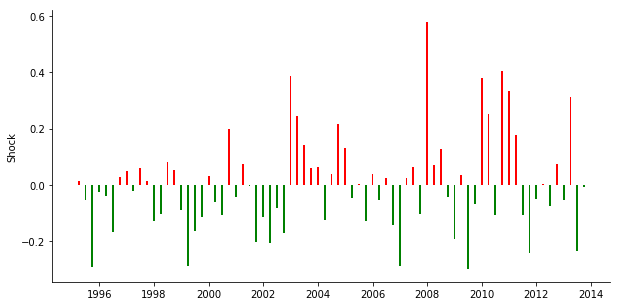

In [37]:
from matplotlib import pyplot as plt

y = quarter_shocks_df.s_shock.values

colors = []

x = quarter_shocks_df.index

QE = [120]

for i in range(len(y)):
    
    if i in QE:
        
        colors.append('orange')
    
    elif y[i] > 0:
        
        colors.append('r')
    
    else:
        
        colors.append('g')

fig = plt.figure(figsize = (10,5))

plt.bar(x,y, width = 25, color = colors)

plt.ylabel('Shock')

#plt.ylim([-0.8,0.8])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

### Export to *.csv*

In [31]:
quarter_shocks_df.to_csv("quarter_shocks.csv")